# Сбор фичей

Cобираем все данные (исходную таблицу и сгенерированные фичи) вместе и делим на тренировочную, валидационную и тестовую выборки в двух вариантах: со сбалансированными и несбалансированными классами

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pymorphy2 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords
import numpy as np

import re

In [134]:
data = "../data/wb_school_task_2.csv.gzip"
data = pd.read_csv(data, compression='gzip')
data = data.drop_duplicates(ignore_index=True)

In [135]:
data = data.drop(['f2', 'f4'], axis=1)

## Общие текстовые фичи

In [136]:
def extract_features(s: pd.Series):
    text = s['text']
    word_count = len(re.findall(r'[а-яА-Яa-zA-Z]+', text))
    # есть отзывы, состоящие из смайликов, пробелов или нижних подчеркиваний
    if word_count == 0:
            return pd.Series({
            'id1': s['id1'],
            'id2': s['id2'],
            'id3': s['id3'],
            'text': text,
            'label': s['label'],
            'text_len': len(text),
            'words_count': 0,
            'sentence_count': 0,
            'number_percentage': 0,
            'caps_percentage': 0,
            'is_empty': 1
        })

    return pd.Series({
        'id1': s['id1'],
        'id2': s['id2'],
        'id3': s['id3'],
        'text': text,
        'label': s['label'],
        'text_len': len(text),
        'words_count': word_count,
        'sentence_count': len(re.split(r'[.!?]+', text)),
        'number_percentage': len(re.findall(r'\d+', text)) / word_count,
        'caps_percentage': len(re.findall(r'[А-ЯA-Z]+', text)) / word_count,
        'is_empty': 0
    })

text_features = data.apply(extract_features, axis=1)
text_features

,id1,id2,id3,text,label,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",0,96,16,2,0.000000,0.062500,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,1,99,15,3,0.000000,0.266667,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",0,32,5,2,0.000000,0.200000,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",1,81,11,3,0.000000,0.181818,0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,0,52,8,3,0.000000,0.375000,0
...,...,...,...,...,...,...,...,...,...,...,...
3117,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",0,66,13,2,0.076923,0.076923,0
3118,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",0,63,10,2,0.000000,0.200000,0
3119,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",0,101,13,1,0.000000,0.076923,0
3120,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",0,40,5,2,0.000000,0.400000,0


In [137]:
merged_dataset = pd.merge(data, text_features, on=['text', 'label', 'id1', 'id2', 'id3'], how='left')
merged_dataset

,id1,id2,id3,text,f1,f3,f5,f6,f7,f8,label,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1.000000,13,4.272727,18,36,0,96,16,2,0.000000,0.062500,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,2.700000,4,4.434783,90,109,1,99,15,3,0.000000,0.266667,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4.000000,0,4.500000,4,6,0,32,5,2,0.000000,0.200000,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,5.000000,30,4.772727,14,15,1,81,11,3,0.000000,0.181818,0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,5.000000,4,5.000000,26,33,0,52,8,3,0.000000,0.375000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,3.000000,1,4.263158,9,9,0,66,13,2,0.076923,0.076923,0
3118,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,4.375000,83,4.183206,18,18,0,63,10,2,0.000000,0.200000,0
3119,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,5.000000,2,4.944828,12,14,0,101,13,1,0.000000,0.076923,0
3120,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,5.000000,19,4.648780,103,155,0,40,5,2,0.000000,0.400000,0


## Фичи из ID

In [138]:
def id_analize(id_col: str, data: pd.DataFrame):
    df = data[[id_col, "label"]]
    df = df.groupby(by=id_col)
    col0 = id_col + "_0"
    col1 = id_col + "_1"
    result = pd.DataFrame(data = {id_col: data[id_col].unique()}, columns=[id_col, col0, col1])
    for idn, table in df:
        if table.shape[0] < 3: 
            result.loc[result[id_col]==idn, col0] = 0
            result.loc[result[id_col]==idn, col1] = 0
            continue
        result.loc[result[id_col]==idn, col0] = (table['label'] == 0).sum()/table.shape[0]
        result.loc[result[id_col]==idn, col1] = (table['label'] == 1).sum()/table.shape[0]
    return result


#for col in ['id1', 'id2']:
    #id_analized = id_analize(col, data)
    #id_analized.to_csv(f"./{col}_data.csv", index=False)
    #merged_dataset = merged_dataset.merge(id_analized, how='left', on=col)

In [139]:
def id_analize2(id_col: str, data: pd.DataFrame):
    df = data[[id_col, "label"]]
    df = df.groupby(by=id_col)
    col0 = id_col+"_pred"
    col1 = id_col+"_in_database"
    result = pd.DataFrame(data = {id_col: data[id_col].unique()}, columns=[id_col, col0, col1])
    for idn, table in df:
        if table.shape[0] < 3: 
            result.loc[result[id_col]==idn, col0] = 0
            result.loc[result[id_col]==idn, col1] = 0
            continue
        result.loc[result[id_col]==idn, col0] = (table['label'] == 1).sum()/table.shape[0]
        result.loc[result[id_col]==idn, col1] = 1
    return result


for col in ['id1', 'id2']:
    id_analized = id_analize2(col, data)
    id_analized.to_csv(f"./{col}_data.csv", index=False)
    merged_dataset = merged_dataset.merge(id_analized, how='left', on=col)

In [141]:
id_analized[id_analized['id2_in_database'] == 0]

,id2,id2_pred,id2_in_database
0,173777575861152844,0,0
1,14366783259208998381,0,0
2,16985421652518589249,0,0
3,2629180387521298831,0,0
4,14531191561111600318,0,0
...,...,...,...
3001,15635360211325277203,0,0
3002,13016265854619171030,0,0
3003,17787644417937804433,0,0
3004,997055248102065549,0,0


In [142]:
merged_dataset.head()

,id1,id2,id3,text,f1,f3,f5,f6,f7,f8,...,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1.0,13,4.272727,18,36,...,96,16,2,0.0,0.062500,0,0,0,0,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,2.7,4,4.434783,90,109,...,99,15,3,0.0,0.266667,0,0,0,0,0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4.0,0,4.500000,4,6,...,32,5,2,0.0,0.200000,0,0,0,0,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,5.0,30,4.772727,14,15,...,81,11,3,0.0,0.181818,0,0,0,0,0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,5.0,4,5.000000,26,33,...,52,8,3,0.0,0.375000,0,0,0,0,0


## Классификация текстов

Вместо того, чтобы конкатенировать векторизированные слова вместе с основными фичами, просто сделаем отдельную классификацию текстов

In [143]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors

from navec import Navec

navec = Navec.load("../model/navec_hudlit_v1_12B_500K_300d_100q.tar")

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

In [144]:
import pickle
with open("../model/text_cl.pkl", 'rb') as f:
    text_classifier = pickle.load(f) 

with open("../model/tf_idf.pkl", 'rb') as f:
    tf_idf = pickle.load(f)

In [145]:
def text_classification(doc):
    local_falls = 0
    doc = re.sub(patterns, ' ', doc)
    vector = tf_idf.transform([doc])
    proba = text_classifier.predict_proba(vector)[0]
    for token in doc.split():
        token = re.sub("[^А-Яа-я]", '', token)
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            try:
                navec[token]
            except:
                local_falls += 1
    return *proba, local_falls

vector_data = data.apply(lambda x: text_classification(x['text']), axis=1)

In [146]:
vector_data.head()

0     (0.4412327999466402, 0.5587672000533598, 2)
1    (0.48205227866352807, 0.5179477213364719, 1)
2     (0.5875346499393287, 0.4124653500606713, 1)
3     (0.4951146734684083, 0.5048853265315917, 0)
4    (0.5327510653776146, 0.46724893462238537, 0)
dtype: object

In [147]:
text_data = vector_data.apply(lambda x: pd.Series(x, index=['text_0', 'text_1', 'falls_count']))

In [148]:
text_data.head()

,text_0,text_1,falls_count
0,0.441233,0.558767,2.0
1,0.482052,0.517948,1.0
2,0.587535,0.412465,1.0
3,0.495115,0.504885,0.0
4,0.532751,0.467249,0.0


In [149]:
full_data = merged_dataset.merge(text_data, left_index=True, right_index=True)

In [150]:
full_data.head()

,id1,id2,id3,text,f1,f3,f5,f6,f7,f8,...,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database,text_0,text_1,falls_count
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1.0,13,4.272727,18,36,...,0.0,0.062500,0,0,0,0,0,0.441233,0.558767,2.0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,2.7,4,4.434783,90,109,...,0.0,0.266667,0,0,0,0,0,0.482052,0.517948,1.0
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4.0,0,4.500000,4,6,...,0.0,0.200000,0,0,0,0,0,0.587535,0.412465,1.0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,5.0,30,4.772727,14,15,...,0.0,0.181818,0,0,0,0,0,0.495115,0.504885,0.0
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,5.0,4,5.000000,26,33,...,0.0,0.375000,0,0,0,0,0,0.532751,0.467249,0.0


In [151]:
full_data.to_csv("./unbalanced_data/full_data.csv", index=False)

# Разделение данных

In [152]:
X_train, X_test = train_test_split(full_data, test_size=0.2, stratify=full_data['label'])
len(X_train), len(X_test)

(2497, 625)

In [153]:
X_train, X_valid = train_test_split(X_train, test_size=0.2, stratify=X_train['label'])
len(X_train), len(X_valid)

(1997, 500)

In [154]:
X_train.to_csv('./unbalanced_data/train_data.csv', index=False)
X_test.to_csv('./unbalanced_data/test_data.csv', index=False)
X_valid.to_csv('./unbalanced_data/valid_data.csv', index=False)

### Сбалансированные классы

In [155]:
(X_train['label']==1).sum()

528

In [156]:
cutted_x = X_train.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_train['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/train_data.csv', index=False)

In [157]:
cutted_x = X_valid.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_valid['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/valid_data.csv', index=False)

In [158]:
cutted_x = X_test.sort_values(by='label', ascending=False, ignore_index=True).loc[:(X_test['label']==1).sum()*2]
cutted_x = cutted_x.sample(frac=1).reset_index(drop=True)
cutted_x.to_csv('./cutted_data/test_data.csv', index=False)

# CatBoost

In [159]:
from catboost import CatBoostClassifier
import optuna
import pandas as pd

In [160]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

In [239]:
data_train = pd.read_csv('./cutted_data/train_data.csv')
Y_train = data_train['label']
X_train = data_train.drop(['label', 'id1', 'id2', 'id3', 'text'], axis=1)
len(X_train)

1057

In [240]:
X_train.head()

,f1,f3,f5,f6,f7,f8,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database,text_0,text_1,falls_count
0,1,5.000000,7,4.647059,13,16,93,17,2,0.0,0.117647,0,0.0,0,0.0,0,0.550632,0.449368,0.0
1,48,4.833333,8,4.931034,75,81,47,6,2,0.0,0.166667,0,0.0,0,0.0,0,0.506344,0.493656,0.0
2,3,2.666667,4,4.305556,5,13,13,3,1,0.0,0.333333,0,0.0,0,0.0,0,0.350112,0.649888,0.0
3,28,5.000000,30,4.857143,113,208,44,7,2,0.0,0.142857,0,0.0,0,0.0,0,0.498364,0.501636,0.0
4,94,5.000000,32,4.915663,113,251,12,2,2,0.0,0.500000,0,0.0,0,0.0,0,0.563125,0.436875,0.0


In [241]:
sum(Y_train==1), sum(Y_train==0)

(528, 529)

In [242]:
data_valid = pd.read_csv('./cutted_data/valid_data.csv')
Y_valid = data_valid['label']
X_valid = data_valid.drop(['label', 'id1', 'id2', 'id3', 'text'], axis=1)
len(X_valid)

265

In [243]:
X_valid.head()

,f1,f3,f5,f6,f7,f8,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database,text_0,text_1,falls_count
0,10,4.600000,12,4.965517,67,79,203,29,8,0.034483,0.310345,0,0.0,0,0.0,0,0.549192,0.450808,2.0
1,2,5.000000,1,3.000000,8,21,41,5,1,0.000000,0.200000,0,0.0,0,0.0,0,0.599831,0.400169,0.0
2,1,5.000000,19,4.894737,10,14,85,13,2,0.000000,0.076923,0,0.0,0,0.0,0,0.504111,0.495889,0.0
3,5,3.600000,1506,4.436848,102,143,27,4,1,0.000000,0.250000,0,0.0,0,0.0,0,0.472241,0.527759,0.0
4,14,4.571429,76,4.398734,41,48,151,24,2,0.125000,0.041667,0,0.0,0,0.0,0,0.391881,0.608119,0.0


In [244]:
sum(Y_valid==1), sum(Y_valid==0)

(132, 133)

In [180]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 50, 120),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1),
        depth=trial.suggest_int("depth", 3, 15),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0),
        eval_metric='F1',
        verbose=False,
        random_state = 42,
        thread_count=-1
    )
    model.fit(X_train, Y_train,
              verbose=False)
    return model.score(X_valid, Y_valid)

In [181]:
study = optuna.create_study(direction='maximize', study_name='classifier_CatBoost')
study.optimize(objective, n_trials=15)

[I 2023-06-15 20:10:54,006] A new study created in memory with name: classifier_CatBoost
[I 2023-06-15 20:10:57,230] Trial 0 finished with value: 0.7320754716981132 and parameters: {'iterations': 98, 'learning_rate': 0.09042101477782208, 'depth': 9, 'l2_leaf_reg': 0.16485075199041488, 'random_strength': 5.790263218664955}. Best is trial 0 with value: 0.7320754716981132.
[I 2023-06-15 20:11:00,051] Trial 1 finished with value: 0.7320754716981132 and parameters: {'iterations': 90, 'learning_rate': 0.09023569258934043, 'depth': 9, 'l2_leaf_reg': 0.00043749079672997416, 'random_strength': 8.470527807978991}. Best is trial 0 with value: 0.7320754716981132.
[I 2023-06-15 20:11:01,127] Trial 2 finished with value: 0.7547169811320755 and parameters: {'iterations': 115, 'learning_rate': 0.06860872661590986, 'depth': 6, 'l2_leaf_reg': 2.5329264271685147e-05, 'random_strength': 7.819823295696981}. Best is trial 2 with value: 0.7547169811320755.
[I 2023-06-15 20:11:01,740] Trial 3 finished with va

In [182]:
study.best_params

{'iterations': 115,
 'learning_rate': 0.06860872661590986,
 'depth': 6,
 'l2_leaf_reg': 2.5329264271685147e-05,
 'random_strength': 7.819823295696981}

In [183]:
params = {'iterations': 115,
 'learning_rate': 0.06860872661590986,
 'depth': 6,
 'l2_leaf_reg': 2.5329264271685147e-05,
 'random_strength': 7.819823295696981}

In [245]:
model = CatBoostClassifier(**params,
                           random_state = 42, 
                           thread_count=-1,
                           eval_metric = 'F1')

In [248]:
X_test

,f1,f3,f5,f6,f7,f8,text_len,words_count,sentence_count,number_percentage,caps_percentage,is_empty,id1_pred,id1_in_database,id2_pred,id2_in_database,text_0,text_1,falls_count
0,1,5.000000,9,4.590164,1,2,173,28,2,0.071429,0.035714,0,0.0,0,0.0,0,0.450930,0.549070,0.0
1,11,4.909091,1,5.000000,27,40,46,6,3,0.000000,0.166667,0,0.0,0,0.0,0,0.562225,0.437775,0.0
2,1,1.000000,15,4.309735,31,143,117,18,2,0.000000,0.111111,0,0.0,0,0.0,0,0.404199,0.595801,0.0
3,19,4.947368,5,4.666667,27,57,65,7,3,0.000000,0.285714,0,0.0,0,0.0,0,0.573578,0.426422,0.0
4,8,5.000000,412,4.351378,16,18,67,8,3,0.000000,0.375000,0,0.0,0,0.0,0,0.474736,0.525264,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,16,4.875000,64,4.233449,33,64,27,4,3,0.000000,0.500000,0,0.0,0,0.0,0,0.520391,0.479609,0.0
327,11,3.909091,0,5.000000,26,77,11,2,1,0.000000,0.000000,0,0.0,0,0.0,0,0.555885,0.444115,0.0
328,1,1.000000,85,2.217742,25,41,40,6,2,0.000000,0.166667,0,0.0,0,0.0,0,0.418560,0.581440,0.0
329,10,5.000000,629,4.703776,17,20,81,13,2,0.000000,0.153846,0,0.0,0,0.0,0,0.487243,0.512757,1.0


In [249]:
model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	learn: 0.6585095	test: 0.7118644	best: 0.7118644 (0)	total: 9.05ms	remaining: 1.03s
1:	learn: 0.6600000	test: 0.7118644	best: 0.7118644 (0)	total: 23.6ms	remaining: 1.33s
2:	learn: 0.6921397	test: 0.7226891	best: 0.7226891 (2)	total: 33.9ms	remaining: 1.27s
3:	learn: 0.6996771	test: 0.7250000	best: 0.7250000 (3)	total: 42.3ms	remaining: 1.17s
4:	learn: 0.7071353	test: 0.7096774	best: 0.7250000 (3)	total: 59.1ms	remaining: 1.3s
5:	learn: 0.7154472	test: 0.7401575	best: 0.7401575 (5)	total: 69.5ms	remaining: 1.26s
6:	learn: 0.7310606	test: 0.7340824	best: 0.7401575 (5)	total: 87.7ms	remaining: 1.35s
7:	learn: 0.7327502	test: 0.7300380	best: 0.7401575 (5)	total: 110ms	remaining: 1.47s
8:	learn: 0.7251908	test: 0.7265918	best: 0.7401575 (5)	total: 141ms	remaining: 1.66s
9:	learn: 0.7288136	test: 0.7313433	best: 0.7401575 (5)	total: 152ms	remaining: 1.59s
10:	learn: 0.7323420	test: 0.7306273	best: 0.7401575 (5)	total: 165ms	remaining: 1.56s
11:	learn: 0.7334594	test: 0.7360595	best: 0.74

In [250]:
model.best_score_

{'learn': {'Logloss': 0.41695912196833784, 'F1': 0.8168462291870715},
 'validation': {'Logloss': 0.5429258273974243, 'F1': 0.7450980392156862}}

In [251]:
data_test = pd.read_csv('./cutted_data/test_data.csv')
Y_test = data_test['label']
X_test = data_test.drop(['label', 'id1', 'id2', 'id3', 'text'], axis=1)

In [252]:
model.score(X_train, Y_train)

0.8098391674550615

In [253]:
model.score(X_valid, Y_valid)

0.7547169811320755

In [254]:
model.score(X_test, Y_test)

0.7401812688821753

In [255]:
model.predict(X_test.loc[30:45]), Y_test.loc[30:45].to_numpy()

(array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1], dtype=int64),
 array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int64))

In [256]:
model.save_model("../model/catboost_with_id.model")

In [257]:
feature_importance = {}
for name, val in zip(X_train.columns, model.get_feature_importance()):
    feature_importance[name] = val

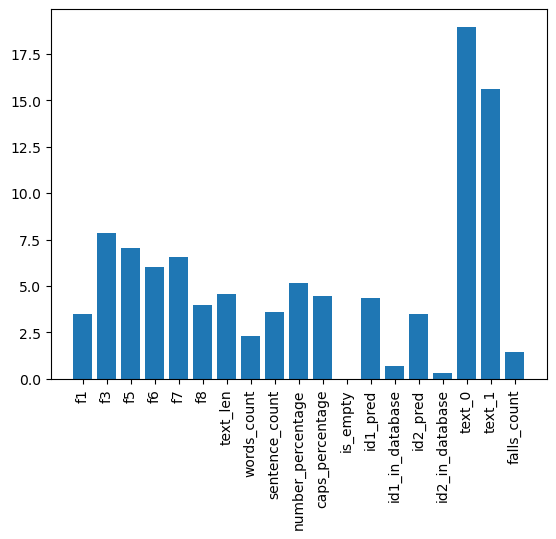

In [258]:
plt.bar(feature_importance.keys(), feature_importance.values())
plt.xticks(rotation=90)
plt.show()